<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/1_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install folderstats tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
# Imports
import re
import os
from collections import Counter
import pandas as pd
from math import log
import folderstats
import tldextract
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%matplotlib inline


In [59]:
# Estilos seaborn
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


# Fuentes de datos

## Dominios malignos

### NetLab360
La empresa de ciberseguridad china NetLab360 ofrece un conjunto de datos actualizado, cuya descarga es gratuita y se encuentra publicada en su [web](https://data.netlab.360.com/feeds/dga/dga.txt).

In [60]:
NETLAB360_PATH='/content/drive/MyDrive/TFM/data_raw/netlab360/dga.txt'
df_netlab360 = pd.read_csv(NETLAB360_PATH, 
                           index_col=None, 
                           header=None, 
                           skiprows=18,
                           sep='\t',
                           names=['family','domain','start','end'])

In [61]:
df_netlab360=df_netlab360.drop(['start','end'],axis=1)

In [62]:
df_netlab360.shape

(1047330, 2)

In [63]:
count=df_netlab360['family'].value_counts()
print("Número de familias DGA distintas: ",len(count))
print(count)

Número de familias DGA distintas:  64
banjori        483339
rovnix         180000
tinba          102199
pykspa_v1       44722
bazardoor       30570
                ...  
blackhole           2
mirai               2
madmax              1
ccleaner            1
xshellghost         1
Name: family, Length: 64, dtype: int64


El dataset consta de muestras pertenecientes a 64 familias de *malware* DGA. La gran mayoría de los datos pertenecen a la familia `banjori`.

Lo podemos verificar visualmente mediante un histograma.

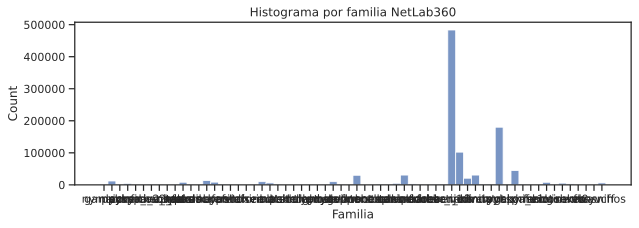

In [64]:
f, ax = plt.subplots(figsize=(10,3)) 
g1=sns.histplot(data=df_netlab360,x="family")
g1.set(title='Histograma por familia NetLab360')
g1.set(xlabel='Familia')
_=g1.plot()

El dataset **no está balanceado**, por lo que si se emplea tal cual es probable que el modelo de clasificación tenga tendencia al *overfitting*, tendiendo a clasificar las muestras de acuerdo al patrón de la familia mayoritaria, `banjori`.

### DGArchive
Analizaremos a continuación la fuente de datos para dominios malignos DGA proporcionada por [DGArchive](https://dgarchive.caad.fkie.fraunhofer.de/site/). 

Este archivo se ofrece por el FKEI del Instituto Fraunhofer previa solicitud  y sólo se puede emplear para fines no comerciales.

El conjunto de datos está compuesto por 93 archivos CSV que ocupan un total de 11 GB. 

Debido al gran tamaño del conjunto de datos, no es viable el análisis de su contenido utilizando la librería `pandas`, dado que excedería la memoria disponible. Por ese motivo, se realiza un análisis exploratorio inicial basado en el tamaño de los archivos. Para ello se hace uso de la librería `folderstats`.

In [65]:
dgarchive_path='/content/drive/MyDrive/TFM/data_raw/dgarchive'
df = folderstats.folderstats(dgarchive_path,  ignore_hidden=True)
# Eliminar la fila correspondiente al propio directorio
df = df.drop(df[df.name =='dgarchive'].index)
df[['name','size']]
df['size']=df['size']/(1024*1024)
df[['name','size']].sort_values(by=['size'], ascending=False).head(10)

,name,size
89,murofet_dga,2507.224755
88,gameover_dga,2271.215793
91,virut_dga,2070.866222
90,necurs_dga,1228.721256
35,qakbot_dga,426.769705
7,cryptolocker_dga,240.716837
10,dyre_dga,214.000111
5,conficker_dga,177.990954
33,qsnatch_dga,176.248784
20,monerominer_dga,175.751209


In [66]:
# Estadísticas del tamaño en megas
df[['size']].describe()

,size
count,92.000000
mean,119.385516
std,425.151380
min,0.000232
25%,0.033678
50%,1.825212
75%,35.087852
max,2507.224755


El tamaño medio de los archivos es de 119 MB. El fichero más grande ocupa  2.4GB y el más pequeño 23 KB. 

Lo más llamativo es el valor tan elevado de la desviación estándar (425 MB), lo que es indicativo de la heterogeneidad tan elevada  del tamaño del conjunto de datos.

Vamos a visualizar el tamaño de los archivos mediante un `barplot`

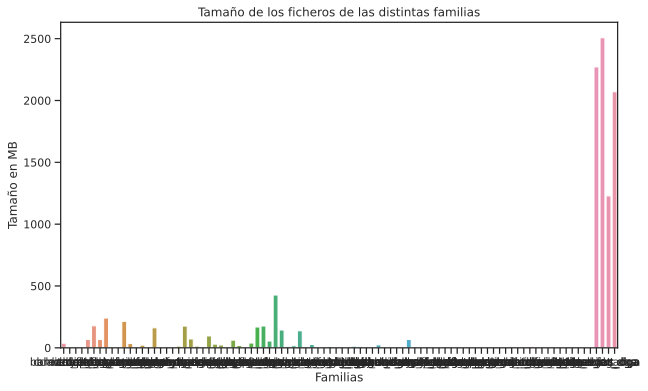

In [67]:
f, ax = plt.subplots(figsize=(10,6)) 
g=sns.barplot(data=df, x="name", y="size")
g.set(title='Tamaño de los ficheros de las distintas familias')
g.set(ylabel='Tamaño en MB')
_=g.set(xlabel='Familias')
#f.set_axis_labels(None)

El diagrama muestra claramente que hay cuatro familias de *malware* DGA que acaparan la mayoría de las muestras.

Estas familias son murofet, gameover, virut y necurs.

Con un diagrama de cajas se visualiza más adecuadamente la distribución del tamaño de los ficheros:

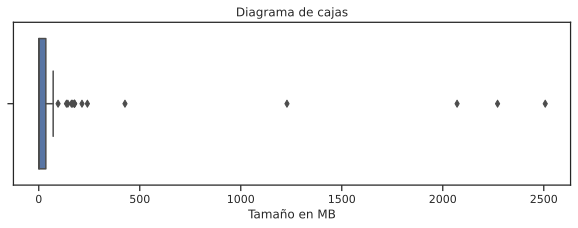

In [68]:
f, ax = plt.subplots(figsize=(10,3)) 
g1=sns.boxplot(data=df,x="size")
g1.set(title='Diagrama de cajas')
g1.set(xlabel='Tamaño en MB')
_=g1.plot()

El diagrama de cajas muestra un gran número de *outliers*, por encima del $Q3+1.5*IQR$ 
(Q3: tercer percentil, IQR: rango intercuartílco=Q3-Q1)

De la observación del tamaño de los archivos, se observa claramente que el *dataset* no se encuentra balanceado, existiendo **cuatro familias por encima de 1000 MB**.

Esta situación no es deseable, dado que los modelos entrenados tenderán a centrarse más en este tipo de datos, produciéndose una situación de *overfitting*. 


Una vez analizado el tamaño de los archivos, vamos a centrarnos en su contenido. 

Tras la conclusión del estudio anterior, limitaremos la carga a un **máximo de 10.000 elementos por familia** para disponer de un *dataset* más balanceado.

In [69]:
# Creamos un array con los archivos CSV a cargar con Pandas
res = []
for path in os.listdir(dgarchive_path):
    if os.path.isfile(os.path.join(dgarchive_path, path)):
        res.append(path)

In [70]:
MAX_ROWS_PER_FAMILY=10000
li = []
suffix = "_dga"
colnames=['domain', 'variant', 'start', 'end','family']
for index, row in df.iterrows():
    family=row['name'][:-len(suffix)]
    df_csv = pd.read_csv(row['path'], 
                         index_col=None, 
                         header=None, 
                         nrows=MAX_ROWS_PER_FAMILY,
                         names=colnames)
    # Obs: La familia no se puede obtener directamente del contenido del CSV 
    # dado que todos los CSV no tienen el mismo número de columnas.
    # Algunos CSV contienen dos columnas, mientras que otros tienen cinco.
    df_csv=df_csv.loc[:,['domain']]
    df_csv['family']=family
    li.append(df_csv)

balanced_df = pd.concat(li, axis=0, ignore_index=True)


In [71]:
balanced_df.shape

(564756, 2)

El conjunto de datos limitado a 10.000 muestras por categoría está compuesto por un total de 564.756 dominios.

In [72]:
balanced_df.sample(10)

,domain,family
80690,sa28537cfb8d637d2fb92d3619f496c9a3.hk,dyre
127191,ogsekwsgnoey.de,locky
156374,b48eqo51c49mvfvcqjrp62j46h14g23osbsdzfr.com,murofetweekly
284965,wibjfzrkfkwzlivgflk.org,qakbot
437005,alyspvqt.in,dmsniff
71635,a95bfrt.com,diamondfox
433983,ahkycblqhm.com,dnschanger
295173,dbcrtuieyggrkpure.com,ranbyus
222189,7784d4c06d47.com,pandabanker
259684,qzgvavielpjg.net,pykspa


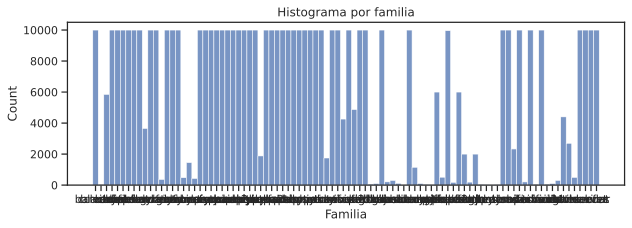

In [73]:
f, ax = plt.subplots(figsize=(10,3)) 
g1=sns.histplot(data=balanced_df,x="family")
g1.set(title='Histograma por familia')
g1.set(xlabel='Familia')
_=g1.plot()

Visualmente se verifica que ahora el *dataset* se encuentra más balanceado.

Finalmente añadimos una columna con la categoría que indica el caracter maligno de las muestras.

In [74]:
balanced_df['category']='malign'

In [75]:
# Familias presentes en NetLab360 y no presentes en DGArchive
set(df_netlab360.family)-set(balanced_df.family)

{'abcbot',
 'antavmu',
 'ares',
 'bazardoor',
 'bigviktor',
 'copperstealer',
 'enviserv',
 'flubot',
 'fobber_v1',
 'fobber_v2',
 'kfos',
 'm0yv',
 'necro',
 'ngioweb',
 'pykspa_v1',
 'pykspa_v2_fake',
 'pykspa_v2_real',
 'shiotob',
 'tordwm',
 'wauchos',
 'zloader'}

## Dominios benignos

### Alexa Top1M
Para los dominios benignos utilizamos como referencia la lista Top1M de de Alexa.

Para obtener un dataset balanceado entre muestras benignas y malignas, cargamos únicamente las primeras 564.756 filas del CSV de Alexa.

In [76]:
ALEXA_CSV='/content/drive/MyDrive/TFM/data_raw/alexa/top-1m.csv'
MAX_ROWS=balanced_df.shape[0]
colnames=['ranking','domain']
df_alexa = pd.read_csv(ALEXA_CSV, 
                         index_col=None, 
                         header=None, 
                         nrows=MAX_ROWS,
                         names=colnames)

In [77]:
df_alexa.shape

(564756, 2)

In [78]:
df_alexa.head()

,ranking,domain
0,1,google.com
1,2,gtld-servers.net
2,3,youtube.com
3,4,facebook.com
4,5,akamaiedge.net


Añadimos una columna adicional especificando que estos dominios son benignos y eliminamos el *ranking*.

In [79]:
df_alexa['category']='benign'
df_alexa=df_alexa.drop(['ranking'], axis=1)
df_alexa.head()

,domain,category
0,google.com,benign
1,gtld-servers.net,benign
2,youtube.com,benign
3,facebook.com,benign
4,akamaiedge.net,benign


A continuación, fusionamos con el *dataset* obtenido de DGArchive

In [80]:
full_df = pd.concat([balanced_df,df_alexa], axis=0, ignore_index=True)

In [81]:
full_df.sample(20)

,domain,family,category
856371,mvusd.net,NaN,benign
958807,autocrit.com,NaN,benign
157088,h34dumqftdzi35d60m49pxl68awf32gupscua67.com,murofetweekly,malign
7107,7519e9d191e8bf446fd3c13c940cdac0.cz.cc,bamital,malign
929757,gkuop.ru,NaN,benign
529509,bynqqly0whoa4s4hfdlvqnih.org,gameover,malign
758506,edddh4.com,NaN,benign
666067,bcc.it,NaN,benign
210639,fobknbknbmeaabdb.info,padcrypt,malign
272656,3cgpfwa.fi,qsnatch,malign


# Extracción de características
Obtenemos los siguientes atributos adicionales a partir de la división del dominio en sus componentes y sus característias léxicas:
- TLD
- SLD
- Número de subdominios
- Número de dígitos en el SLD
- Longitud del SLD
- Número de guiones en el SLD
- Índice de entropía de Shannon del SLD (aleatoriedad en los caracteres)
- Ratio Vocal/Consonante


In [82]:
# Extracción de características
def shannon(string):
  '''
    Calcula el índice de entropia de shannon
  '''
  # Ref: reddit.com/r/learnpython/comments/g1sdkh/python_programming_challenge_calculating_shannon/ 
  counts = Counter(string)
  frequencies = ((i / len(string)) for i in counts.values())
  return - sum(f * log(f, 2) for f in frequencies)

def num_digits(domain):
    p = re.compile("\d")
    digits = p.findall(domain)
    return len(digits)


def ratio_vc(domain):
  '''
    Calcula el ratio entre vocales y consonantes
  '''
  # Ref: https://pencilprogrammer.com/python-programs/count-vowels-and-consonants/ 
  v = 0
  c = 0
  for x in domain:
    if x in ['a', 'e', 'i', 'o', 'u']:
        v += 1
    elif x != '-':
        c += 1
  try:
    ratio = v / c
  except: 
    ratio = 0  
  return ratio

#balanced_df['domain_upper'] = balanced_df['domain'].apply(lambda x: x.upper())
full_df['tld'] = full_df['domain'].apply(lambda d:tldextract.extract(d)[-1])
full_df['sld'] = full_df['domain'].apply(lambda d:tldextract.extract(d)[-2])
full_df['subdomains_number'] = full_df['domain'].apply(lambda d:len(tldextract.extract(d)))
full_df['digits'] = full_df['sld'].apply(num_digits)
full_df['length'] = full_df['sld'].apply(lambda x: len(x))
full_df['num_dashes'] = full_df['sld'].apply(lambda x: len(re.compile("\-").findall(x)))
full_df['entropy'] = full_df['sld'].apply(lambda x:shannon(x))
full_df['ratio_vc'] = full_df['sld'].apply(lambda x:ratio_vc(x))


In [83]:
full_df.shape

(1129512, 11)

In [84]:
full_df.sample(10)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc
1070341,turkkon.org,NaN,benign,org,turkkon,3,0,7,0,2.521641,0.400000
117450,eca7b8cd.net,infy,malign,net,eca7b8cd,3,2,8,0,2.750000,0.333333
379699,dvndvnd.biz,tofsee,malign,biz,dvndvnd,3,0,7,0,1.556657,0.000000
858707,adendorff.co.za,NaN,benign,co.za,adendorff,3,0,9,0,2.725481,0.500000
122705,fgnalyh.tf,locky,malign,tf,fgnalyh,3,0,7,0,2.807355,0.166667
86160,u360b9fa9aa4bc55eb435361c3f9020724.to,dyre,malign,to,u360b9fa9aa4bc55eb435361c3f9020724,3,22,34,0,3.777777,0.172414
279083,t2n4du709q34.net,qadars,malign,net,t2n4du709q34,3,7,12,0,3.418296,0.090909
1120940,glamglow.com,NaN,benign,com,glamglow,3,0,8,0,2.500000,0.333333
550275,rdbvqmpajnmjhbv.me,necurs,malign,me,rdbvqmpajnmjhbv,3,0,15,0,3.373557,0.071429
61040,sprqycvodcwtn.co.uk,cryptolocker,malign,co.uk,sprqycvodcwtn,3,0,13,0,3.546594,0.083333


In [85]:
len(full_df[full_df['subdomains_number']>3])

0

No hay ninguna muestra que utilice subdominios, todas las muestras están compuestas por un TLD+SLD, por ejemplo, "caliwaual.org".

# Análisis exploratorio
## Distribución por TLD
Analizamos en primer lugar los dominios de nivel superior. Al utilizar la librería `tldextract`, además de los TLD clásicos (.COM, .NET, ...), se consideran TLD dominos del tipo ".CO.UK".


In [42]:
len(full_df[full_df['category']=='benign']['tld'].value_counts())

1929

In [43]:
print("Total dominios TLD distintos: ",len(full_df['tld'].value_counts()))
print("Total dominios TLD benignos: ",len(full_df[full_df['category']=='benign']['tld'].value_counts()))
print("Total dominios TLD malignos: ",len(full_df[full_df['category']=='malign']['tld'].value_counts()))

Total dominios TLD distintos:  1931
Total dominios TLD benignos:  1929
Total dominios TLD malignos:  120


En el caso de las muestras malignas, se utilizan 120 TLD distintos. Los dominios benignos tienen hasta 1942 TLD distintos

In [47]:
top=15
top_tld=full_df["tld"].value_counts()[0:top].index
top_tld_df=full_df[full_df["tld"].isin(top_tld)]

In [48]:
top_tld_df

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc
0,47faeb4f1b75a48499ba14e9b1cd895a.org,bamital,malign,org,47faeb4f1b75a48499ba14e9b1cd895a,3,18,32,0,3.426109,0.230769
1,47faeb4f1b75a48499ba14e9b1cd895a.info,bamital,malign,info,47faeb4f1b75a48499ba14e9b1cd895a,3,18,32,0,3.426109,0.230769
2,47faeb4f1b75a48499ba14e9b1cd895a.co.cc,bamital,malign,cc,co,3,0,2,0,1.000000,1.000000
3,47faeb4f1b75a48499ba14e9b1cd895a.cz.cc,bamital,malign,cc,cz,3,0,2,0,1.000000,0.000000
4,9b86bb2ef4bad69cca0110076215e1f4.org,bamital,malign,org,9b86bb2ef4bad69cca0110076215e1f4,3,19,32,0,3.765320,0.142857
...,...,...,...,...,...,...,...,...,...,...,...
1129502,toadmin.ru,NaN,benign,ru,toadmin,3,0,7,0,2.807355,0.750000
1129505,bamigo.com,NaN,benign,com,bamigo,3,0,6,0,2.584963,1.000000
1129508,cdmatech.com,NaN,benign,com,cdmatech,3,0,8,0,2.750000,0.333333
1129509,gifajans.info,NaN,benign,info,gifajans,3,0,8,0,2.750000,0.600000


Text(0, 0.5, 'Número de dominios')

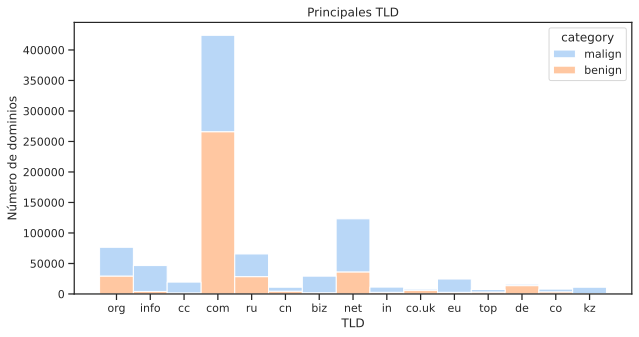

In [81]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=top_tld_df, ax=ax, multiple="stack",
             x="tld",
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Principales TLD")
ax.set_xlabel("TLD")
ax.set_ylabel("Número de dominios")

El histograma anterior muestra los TLD que cuentan con más de 1000 muestras.
El TLD mayoritario es el .COM, seguido del .NET.

Se observa que hay TLD que son de uso prácticamente exclusivo por parte de DGA, como .INFO, .CC, .BIZ o .EU.

## Longitud del dominio
Analizaremos a continuación la longitud de los dominios

Text(0, 0.5, 'Número de dominios')

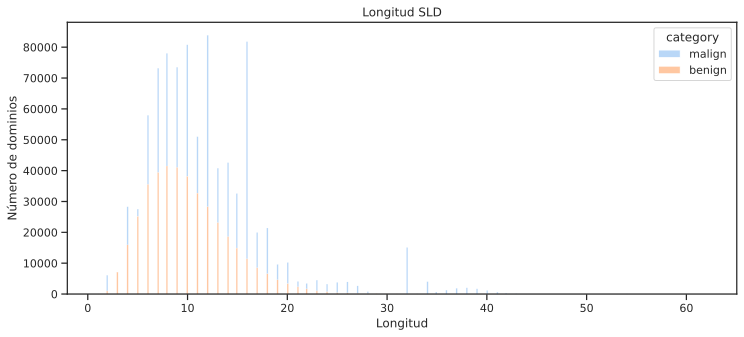

In [97]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=top_tld_df, ax=ax, stat="count", multiple="stack",
             x="length", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Longitud SLD")
ax.set_xlabel("Longitud")
ax.set_ylabel("Número de dominios")

Se puede observar que, aunque siguen una distribución similar, por un lado, a partir de los 25 caracteres únicamente hay muestras malignas y, por otro lado, hay determinadas longitudes (12 y 16 caracteres, probablemente correspondientes a familias de DGA concretas) para las que hay un pico evidente en el caso de los dominios malignos.

## Dígitos

Text(0, 0.5, 'Número de dominios')

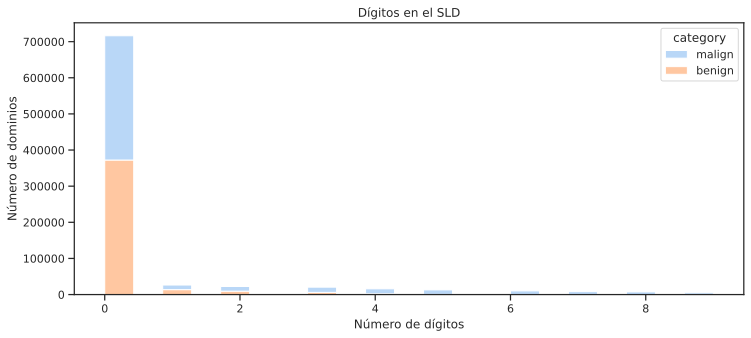

In [101]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
MAX_DIGITS_TO_PLOT=10
sns.histplot(data=top_tld_df[top_tld_df['digits']<MAX_DIGITS_TO_PLOT], ax=ax, multiple="stack",
             x="digits",
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Dígitos en el SLD")
ax.set_xlabel("Número de dígitos")
ax.set_ylabel("Número de dominios")

La gran mayoría de dominios del conjunto de datos no tiene ningún dígito y hay una distribución equitativa entre dominios benignos y malignos. 

Se observa que a partir de 4 dígitos, únicamente hay muestras malignas.

## Guiones
Analizamos la distribución de los dominios en función del número de guiones contenidos en el SLD.

[]

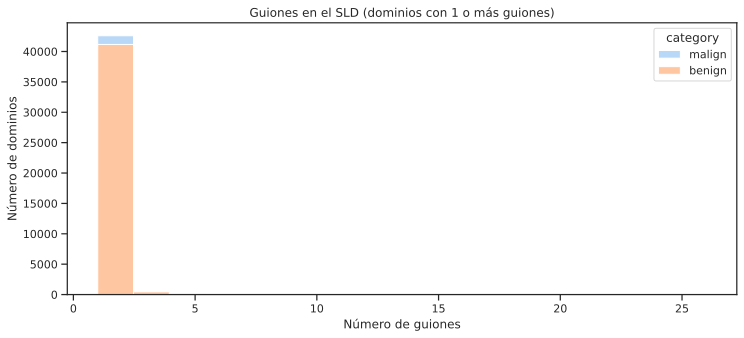

In [102]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=top_tld_df[top_tld_df['num_dashes']>0], ax=ax, multiple="stack",
             x="num_dashes", 
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Guiones en el SLD (dominios con 1 o más guiones)")
ax.set_xlabel("Número de guiones")
ax.set_ylabel("Número de dominios")
ax.plot()

La gran mayoría de dominios no tiene ningún guión, con lo que el histograma no es representativo. Calculamos a continuación el número de elementos por número de guiones y categoría:

In [85]:
full_df[['num_dashes','category']].value_counts(ascending=False)

num_dashes  category
0           malign      559655
            benign      510236
1           benign       48228
2           benign        5385
1           malign        5042
3           benign         650
4           benign         217
26          malign          59
5           benign          28
6           benign          10
7           benign           1
10          benign           1
dtype: int64

La distribución de dominios sin guion es similar entre los dominios malignos y benignos, sin embargo la mayoría de los dominios con más de un guion son benignos. 

Llama la atención el caso de dominios malignos con 26 guiones, sin duda correspondiente a una familia de DGA específica.

## Ratio vocal-consonante

Text(0, 0.5, 'Dominios')

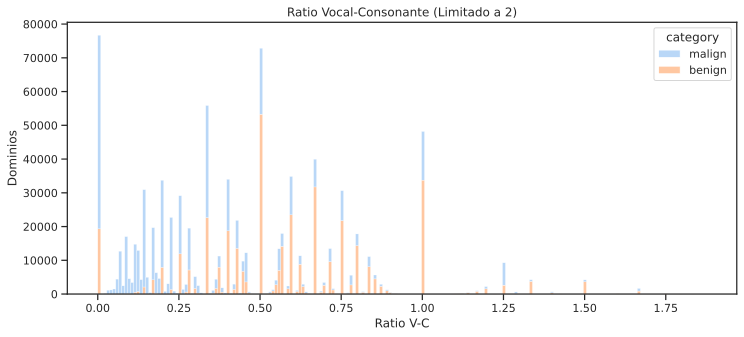

In [95]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
MAX_RATIO_TO_PLOT=2
sns.histplot(data=top_tld_df[top_tld_df['ratio_vc']<MAX_RATIO_TO_PLOT], ax=ax, stat="count", multiple="stack",
             x="ratio_vc", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Ratio Vocal-Consonante (Limitado a 2)")
ax.set_xlabel("Ratio V-C")
ax.set_ylabel("Dominios")

Este gráfico se ha limitado a un máximo de ratio 2, dado que existen dominios con ratios superiores a 10 que hacían la gráfica ilegible.

En la gráfica se puede observar que hay un gran número de dominios formados únicamente por vocales (ratio 0), otro gran número de dominios tienen un ratio de 0.5, tanto para dominios legítimos como para DGA, lo que indica que tiene el mismo número de consontantes y vocales.

Respecto a la distribución benigno-maligno, se observa que los dominios malignos son mayoritarios en el rango 0-0.25, mientras que los benignos lo son en el rango 0.5-1.

# Guardar CSV
Por último guardamos el CVS resultante para utilizarlo en las siguientes fases del proyecto

In [127]:
full_df.to_csv('/content/drive/MyDrive/TFM/data_processed/dga.csv')